# Local Outlier Factor

## Import Data

In [14]:
import pandas as pd

train_df = pd.read_csv("../data/processed_train_df.csv")
print(train_df.shape)

test_df = pd.read_csv("../data/processed_test_df.csv")
print(test_df.shape)

df = pd.concat([train_df, test_df])
print(df.shape)

(227845, 31)
(56962, 31)
(284807, 31)


In [15]:
# Exclude labels

y_train = train_df['Class']
X_train = train_df.drop(columns=['Class'])

y_test = test_df['Class']
X_test = test_df.drop(columns=['Class'])

labels = df['Class']
df_unlabelled = df.drop(columns=['Class'])

In [16]:
from sklearn.model_selection import train_test_split

# Build a validation with 20% of the data (25% of the train dataset)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

## Model Building

In [17]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=35,   # hyperparameter to tune
    novelty=True,     # allow scoring unseen data
    contamination=0.0015,  # expected fraction of anomalies (used for predict threshold only)
    n_jobs=-1
)

lof.fit(X_train)

LocalOutlierFactor(contamination=0.0015, n_jobs=-1, n_neighbors=35,
                   novelty=True)

In [18]:
scores = -lof.decision_function(X_test)
pred_labels = (lof.predict(X_test) == -1).astype(int)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


ROC: 0.4999
PR AUC: 0.0036


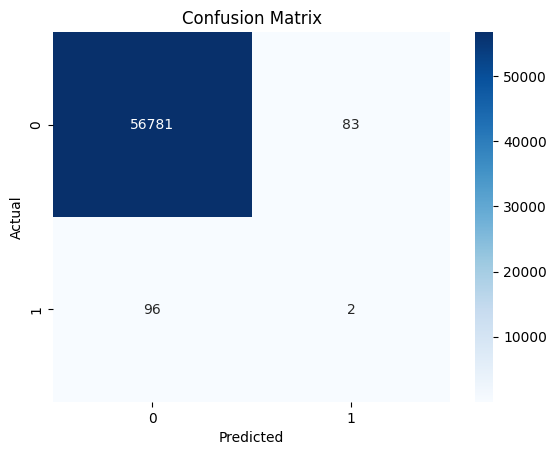

In [19]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

roc = roc_auc_score(y_test, scores)
pr_auc = average_precision_score(y_test, scores)

print(f"ROC: {roc.round(4)}")
print(f"PR AUC: {pr_auc.round(4)}")

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

This model clearly performs terribly. Let's try tuning it.

## Hyperparameter Tuning

In [20]:
# Find a good random_state so that the sample mean is close to the actual mean

mean = 0
i = 0

while abs(mean-0.00172) > 0.00002:
    i+=1
    train_sample = train_df.sample(frac=0.5, random_state=i)
    X_sample = train_sample.drop(columns=['Class'])
    y_sample = train_sample['Class']
    mean = y_sample.mean()

print(i)
print(mean)

3
0.001738031284563122


In [21]:
import numpy as np

def precision_recall_at_k(y_true, scores, k=0.01):
    """
    Compute Precision@k and Recall@k for anomaly scores.
    y_true: array-like of shape (n,) with 0/1 labels
    scores: array-like of shape (n,) with higher = more anomalous
    k: fraction of samples to flag (e.g. 0.01 = top 1%)
    """
    n = len(scores)
    top_n = max(1, int(np.ceil(k * n)))  # at least one sample

    # Get indices of top-k scores
    idx = np.argsort(-scores)[:top_n]

    # Precision = frauds / flagged
    precision = y_true.iloc[idx].mean()

    # Recall = frauds caught / total frauds
    recall = y_true.iloc[idx].sum() / y_true.sum()

    return precision, recall

In [22]:
from sklearn.model_selection import ParameterGrid

def tune_LOF(param_grid, PRIMARY, SECONDARY, X_train=X_train, X_val=X_val, y_val=y_val):

    runs = []
    best_tuple = (-np.inf, -np.inf)
    best_params, best_model, best_scores = None, None, None

    for params in ParameterGrid(param_grid):
        lof = LocalOutlierFactor(
            novelty=True,
            n_jobs=-1,
            metric="minkowski",
            **params
        )
        lof.fit(X_train)
        scores = -lof.decision_function(X_val)

        roc = roc_auc_score(y_val, scores)
        pr_auc = average_precision_score(y_val, scores)
        p_at_1,  r_at_1  = precision_recall_at_k(y_val, scores, k=0.01)
        p_at_05, r_at_05 = precision_recall_at_k(y_val, scores, k=0.005)

        runs.append({
            **params,
            "ROC": roc,
            "pr_auc": pr_auc,
            "p_at_1": p_at_1, "r_at_1": r_at_1,
            "p_at_05": p_at_05, "r_at_05": r_at_05
        })

        primary_val   = r_at_1 if PRIMARY == "r_at_1" else pr_auc
        secondary_val = pr_auc if SECONDARY == "pr_auc" else r_at_1

        if (primary_val, secondary_val) > best_tuple:
            best_tuple  = (primary_val, secondary_val)
            best_params = params
            best_model  = lof
            best_scores = scores

    results_df = pd.DataFrame(runs).sort_values(
        by=[PRIMARY, SECONDARY], ascending=[False, False]
    ).reset_index(drop=True)

    print("Top configs:")
    display(results_df.head(10))
    print("\nSelected params:", best_params)
    print(f"Selected {PRIMARY}={best_tuple[0]:.4f}, {SECONDARY}={best_tuple[1]:.4f}")

    return(best_tuple, best_params, best_model, best_scores)

In [23]:
PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

param_grid = {
    "n_neighbors": [100, 200, 300], # Narrowed down through multiple iterations
}

# First tune on a sample of the train dataset
tune_LOF(param_grid, PRIMARY, SECONDARY, X_sample)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,300,0.962465,0.372191,0.136842,0.787879,0.266667,0.767677
1,200,0.962364,0.276550,0.136842,0.787879,0.259649,0.747475
2,100,0.836257,0.019313,0.031579,0.181818,0.045614,0.131313



Selected params: {'n_neighbors': 300}
Selected r_at_1=0.7879, pr_auc=0.3722


((0.7878787878787878, 0.37219068874735806),
 {'n_neighbors': 300},
 LocalOutlierFactor(n_jobs=-1, n_neighbors=300, novelty=True),
 array([-0.21643433, -0.10156226, -0.39048619, ..., -0.51152622,
        -0.43457247, -0.36997519]))

In [30]:
PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

param_grid = {
    "n_neighbors": [200, 300, 400], # Narrowed down through multiple iterations
}

# Try tuning on the whole train dataset
tune_LOF(param_grid, PRIMARY, SECONDARY)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,400,0.962444,0.362085,0.136842,0.787879,0.266667,0.767677
1,300,0.961830,0.276599,0.136842,0.787879,0.263158,0.757576
2,200,0.927883,0.059250,0.066667,0.383838,0.094737,0.272727



Selected params: {'n_neighbors': 400}
Selected r_at_1=0.7879, pr_auc=0.3621


((0.7878787878787878, 0.3620854481177362),
 {'n_neighbors': 400},
 LocalOutlierFactor(n_jobs=-1, n_neighbors=400, novelty=True),
 array([-0.20896509, -0.11626683, -0.38604448, ..., -0.51058878,
        -0.42619101, -0.36862622]))

It looks like p_at_1 and r_at_1 have stopped improving at n=300, but let's see if we can further improve the PR AUC by using even more neighbours.

In [31]:
PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

param_grid = {
    "n_neighbors": [400, 500, 600], # Narrowed down through multiple iterations
}

# First tune on a sample of the train dataset
tune_LOF(param_grid, PRIMARY, SECONDARY, X_sample)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,400,0.962049,0.389634,0.136842,0.787879,0.266667,0.767677
1,500,0.961383,0.384383,0.136842,0.787879,0.259649,0.747475
2,600,0.961376,0.384253,0.136842,0.787879,0.259649,0.747475



Selected params: {'n_neighbors': 400}
Selected r_at_1=0.7879, pr_auc=0.3896


((0.7878787878787878, 0.3896338331339095),
 {'n_neighbors': 400},
 LocalOutlierFactor(n_jobs=-1, n_neighbors=400, novelty=True),
 array([-0.23959298, -0.10652425, -0.38573855, ..., -0.50527097,
        -0.43396927, -0.38746282]))

In [32]:
PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

param_grid = {
    "n_neighbors": [400, 500, 600], # Narrowed down through multiple iterations
}

# Try tuning on the whole train dataset
tune_LOF(param_grid, PRIMARY, SECONDARY)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,600,0.961999,0.386524,0.136842,0.787879,0.266667,0.767677
1,500,0.962269,0.384378,0.136842,0.787879,0.266667,0.767677
2,400,0.962444,0.362085,0.136842,0.787879,0.266667,0.767677



Selected params: {'n_neighbors': 600}
Selected r_at_1=0.7879, pr_auc=0.3865


((0.7878787878787878, 0.3865241540193627),
 {'n_neighbors': 600},
 LocalOutlierFactor(n_jobs=-1, n_neighbors=600, novelty=True),
 array([-0.23658324, -0.10685334, -0.38316084, ..., -0.50799994,
        -0.42701753, -0.38585544]))

It appears as though the improvements in p_at_05, r_at_05 and PR AUC have now become minute for the additional neighbors.

## Evaluation

In [ ]:
lof = LocalOutlierFactor(
    n_neighbors=500,
    novelty=True,
    n_jobs=-1
)

lof.fit(X_train)

scores = -lof.decision_function(X_test)

roc = roc_auc_score(y_test, scores)
pr_auc = average_precision_score(y_test, scores)
p_at_1, r_at_1 = precision_recall_at_k(y_test, scores, k=0.01)
p_at_05, r_at_05 = precision_recall_at_k(y_test, scores, k=0.005)

print({"ROC": roc, "pr_auc": pr_auc, "p_at_1": p_at_1, "r_at_1": r_at_1, "p_at_05": p_at_05, "r_at_05": r_at_05})

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


{'ROC': 0.9495164976513959, 'pr_auc': 0.506404795078435, 'p_at_1': 0.14385964912280702, 'r_at_1': 0.8367346938775511, 'p_at_05': 0.2771929824561403, 'r_at_05': 0.8061224489795918}


Now let's try out these parameters on the whole dataset.

## Evaluation on the Whole Dataset

In [34]:
scores = -lof.decision_function(df_unlabelled)

roc = roc_auc_score(labels, scores)
pr_auc = average_precision_score(labels, scores)
p_at_1,  r_at_1  = precision_recall_at_k(labels, scores, k=0.01)
p_at_05, r_at_05 = precision_recall_at_k(labels, scores, k=0.005)

print({
    "ROC": roc,
    "pr_auc": pr_auc,
    "p_at_1": p_at_1, "r_at_1": r_at_1,
    "p_at_05": p_at_05, "r_at_05": r_at_05
})

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


{'ROC': 0.9604611869149484, 'pr_auc': 0.4542843905162742, 'p_at_1': 0.14215514215514216, 'r_at_1': 0.823170731707317, 'p_at_05': 0.27649122807017545, 'r_at_05': 0.8008130081300813}


Note that these scores can be marginally improved upon by setting a higher n_neighbors, but the improvements are marginal compared to the computational cost.

On the whole dataset, our tuned Local Outlier Factor (LOF) model achieved ROC AUC = 0.96 and PR AUC = 0.45, substantially higher than the Isolation Forest baseline.

At a 1% review budget, the model reached 14% precision and 82% recall, representing an ~83× improvement over random guessing.
In practice, this means fraud investigators could detect ~404 fraud cases (over 80% of all frauds in the dataset) while only reviewing 1% of transactions.

At a 0.5% review budget, the model achieved 28% precision and 80% recall, a ~162× improvement over random guessing.
This translates to catching ~394 fraud cases (around 80% of the total) while reviewing just 0.5% of transactions (~1,425 cases out of 285,000).

## Reducing Model Complexity

In practice, it is feasible that increased PR AUC is not deemed to be worth the extra computational cost that comes with it, as only the top x% of transactions flagged as 'most suspicious' will be manually reviewed.

In this case, can we simplify the model so that it runs more efficiently, whilst maintaining good p_at_1 and r_at_1 scores?

Note that this assumes that the top 1% of transactions will be reviewed. Of course, if the percentage differs from 1% that would affect the model complexity necessary to retain performance.

In [35]:
PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

param_grid = {
    "n_neighbors": [250, 300, 350], # Narrowed down through multiple iterations
}

tune_LOF(param_grid, PRIMARY, SECONDARY, X_train)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,350,0.962471,0.334987,0.136842,0.787879,0.263158,0.757576
1,300,0.961830,0.276599,0.136842,0.787879,0.263158,0.757576
2,250,0.958896,0.145296,0.115789,0.666667,0.182456,0.525253



Selected params: {'n_neighbors': 350}
Selected r_at_1=0.7879, pr_auc=0.3350


((0.7878787878787878, 0.33498674083955843),
 {'n_neighbors': 350},
 LocalOutlierFactor(n_jobs=-1, n_neighbors=350, novelty=True),
 array([-0.19985498, -0.12122769, -0.38322507, ..., -0.50549505,
        -0.42460746, -0.35949611]))

In [36]:
lof = LocalOutlierFactor(
    n_neighbors=300,
    novelty=True,
    n_jobs=-1
)

lof.fit(X_train)

scores = -lof.decision_function(X_test)

roc = roc_auc_score(y_test, scores)
pr_auc = average_precision_score(y_test, scores)
p_at_1, r_at_1 = precision_recall_at_k(y_test, scores, k=0.01)
p_at_05, r_at_05 = precision_recall_at_k(y_test, scores, k=0.005)

print({"ROC": roc, "pr_auc": pr_auc, "p_at_1": p_at_1, "r_at_1": r_at_1, "p_at_05": p_at_05, "r_at_05": r_at_05})

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


{'ROC': 0.9522805218035442, 'pr_auc': 0.34763110193208335, 'p_at_1': 0.14385964912280702, 'r_at_1': 0.8367346938775511, 'p_at_05': 0.26666666666666666, 'r_at_05': 0.7755102040816326}


We can see that reducing n_neighbors to 400, we can retain strong p_at_1 and r_at_1 values whilst reducing model complexity.